In [1]:
import numpy as np  
# NumPy is used for numerical operations, such as working with arrays and matrices.
import pandas as pd  
# Pandas is used for data manipulation and analysis, particularly for handling structured data in DataFrames.
import matplotlib.pyplot as plt  
# Matplotlib's pyplot module is used for creating static, animated, and interactive visualizations.

from sklearn.model_selection import train_test_split  
# Scikit-learn's train_test_split function is used to split data into training and testing sets.
from sklearn.preprocessing import StandardScaler  
# Scikit-learn's StandardScaler is used to standardize features by removing the mean and scaling to unit variance.
from sklearn.metrics import mean_squared_error, mean_absolute_error  
# These are Scikit-learn's metrics for evaluating model performance by calculating the errors between predicted and actual values.

import tensorflow as tf  
# TensorFlow is an open-source platform for machine learning and deep learning.
from tensorflow.keras.models import Sequential  
# Sequential is a Keras API used within TensorFlow for creating linear stacks of layers in a neural network model.
from tensorflow.keras.layers import Dense, LSTM  
# Dense is a fully connected neural network layer, and LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) layer used for sequence prediction problems.
from tensorflow.keras.callbacks import EarlyStopping  
# EarlyStopping is a Keras callback function used to stop training when a monitored metric has stopped improving, preventing overfitting.

In [3]:
# Simulate time series data
np.random.seed(42)  
# Set the random seed for reproducibility, ensuring that the random numbers generated are the same each time the code is run.
timesteps = 500  
# Define the number of time steps or days in the simulated time series data.
features = 5  
# Define the number of features or variables in the simulated dataset.

# Generate time-dependent features
dates = pd.date_range(start='2020-01-01', periods=timesteps, freq='D')  
# Create a range of dates starting from January 1, 2020, for the number of timesteps, with daily frequency.
X = np.array([np.sin(0.1 * np.arange(timesteps) + np.random.rand()) for _ in range(features)]).T  
# Generate an array of sine wave values with random phase shifts to simulate time-dependent features.
noise = np.random.randn(timesteps) * 0.1  
# Generate random noise to add to the target variable, scaled by 0.1 to keep the noise small.

# Generate a target variable with some dependency on features
y = 0.5 * X[:, 0] + 0.2 * X[:, 1] + 0.3 * X[:, 2] + noise  
# Create the target variable `y` as a linear combination of the first three features plus some random noise to simulate a dependent variable.

# Create a DataFrame with dates as the index
df = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(1, features + 1)], index=dates)  
# Create a Pandas DataFrame from the feature array `X`, setting custom column names and using dates as the index.
df['Target'] = y  
# Add the target variable `y` as a new column in the DataFrame.

# Display the first few rows
df.head()  
# Print the first few rows of the DataFrame to inspect the simulated data.


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Target
2020-01-01,0.365845,0.813831,0.668354,0.563535,0.155386,0.574099
2020-01-02,0.456929,0.867778,0.739276,0.643191,0.253231,0.724855
2020-01-03,0.543449,0.913055,0.802810,0.716421,0.348545,0.637091
2020-01-04,0.624538,0.949210,0.858324,0.782492,0.440377,0.707091
2020-01-05,0.699387,0.975880,0.905261,0.840745,0.527809,0.759310


In [5]:
# Calculate the split index for 80% training and 20% testing
split_index = int(timesteps * 0.8)  
# Calculate the index that corresponds to 80% of the total number of time steps, to split the data into training and testing sets.

# Split the data into training and testing sets
train_df = df.iloc[:split_index]  
# Select the first 80% of the data for the training set using slicing.
test_df = df.iloc[split_index:]  
# Select the remaining 20% of the data for the testing set using slicing.

# Separate the features and the target variable for training and testing
X_train = train_df.drop(columns=['Target']).values  
# Extract training features by dropping the 'Target' column and converting the DataFrame to a NumPy array.
y_train = train_df['Target'].values  
# Extract the training target variable as a NumPy array.
X_test = test_df.drop(columns=['Target']).values  
# Extract testing features by dropping the 'Target' column and converting the DataFrame to a NumPy array.
y_test = test_df['Target'].values  
# Extract the testing target variable as a NumPy array.

# Reshape the input data to 3D for the LSTM model (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  
# Reshape training data to 3D format required for LSTM input: (number of samples, time steps, number of features).
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  
# Reshape testing data to 3D format required for LSTM input: (number of samples, time steps, number of features).


In [6]:
# Scale the features to have mean 0 and variance 1
scaler = StandardScaler()  
# Initialize the StandardScaler, which will standardize features by removing the mean and scaling to unit variance.

X_train = scaler.fit_transform(X_train.reshape(-1, features)).reshape(-1, 1, features)  
# Reshape X_train to 2D (flattening the data) before scaling to fit the scaler to the training data and transform it.
# Then reshape back to 3D for LSTM input format after scaling.

X_test = scaler.transform(X_test.reshape(-1, features)).reshape(-1, 1, features)  
# Reshape X_test to 2D (flattening the data) before scaling.
# Use the already fitted scaler to transform the testing data to ensure the same scaling as the training data.
# Then reshape back to 3D for LSTM input format after scaling.

In [7]:
def create_lstm_model():
    # Define a function to create and return an LSTM model.
    
    model = Sequential([  # Initialize a Sequential model, which is a linear stack of layers in Keras.
        LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),  
        # Add an LSTM layer with 50 units (neurons) and ReLU activation function.
        # The input shape is defined as (timesteps, features), where `X_train.shape[1]` is the number of timesteps 
        # and `X_train.shape[2]` is the number of features.
        
        Dense(1)  # Add a Dense layer with 1 unit, which outputs a single prediction (e.g., for regression).
    ])
    
    model.compile(optimizer='adam', loss='mse')  
    # Compile the model using the Adam optimizer, which is a popular choice for training neural networks, 
    # and mean squared error (MSE) as the loss function, suitable for regression tasks.
    
    return model  # Return the constructed and compiled LSTM model.

In [8]:
# Create the model
model_without_es = create_lstm_model()  
# Initialize the LSTM model using the `create_lstm_model` function defined earlier. This model does not have Early Stopping integrated.

# Train the model without Early Stopping
history_without_es = model_without_es.fit(X_train, y_train,  
                                          # Train the model on the training data (X_train, y_train).
                                          
                                          validation_data=(X_test, y_test),  
                                          # Use the testing data (X_test, y_test) as the validation set to monitor the model's performance 
                                          # during training.
                                          
                                          epochs=100,  
                                          # Set the number of epochs to 100, meaning the model will iterate over the entire training data 100 times.
                                          
                                          batch_size=32,  
                                          # Set the batch size to 16, meaning the model will update its weights after processing every 32 samples.
                                          
                                          verbose=0)  
                                          # Set verbosity to 0 to suppress the output during training, meaning no progress output will be displayed.

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


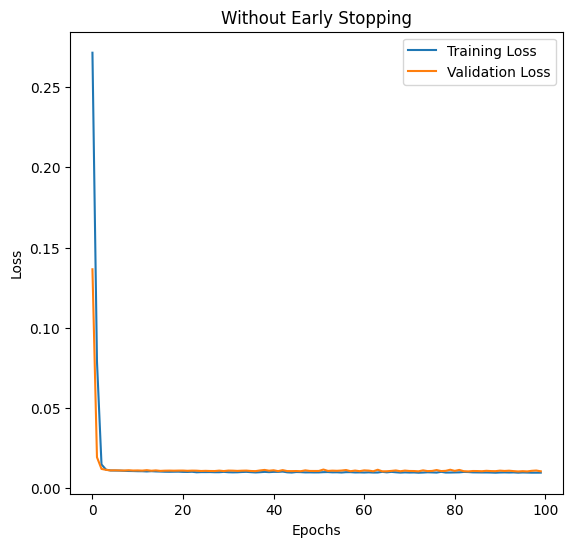

In [9]:
plt.figure(figsize=(14, 6))  
# Create a new figure for plotting with a specified size of 14 inches wide by 6 inches tall. This sets up the canvas for the plots.

# Without Early Stopping
plt.subplot(1, 2, 1)  
# Add a subplot to the figure. The parameters (1, 2, 1) indicate that there will be 1 row and 2 columns of subplots, 
# and this command targets the first subplot (the one on the left).

plt.plot(history_without_es.history['loss'], label='Training Loss')  
# Plot the training loss over epochs from the model built

plt.plot(history_without_es.history['val_loss'], label='Validation Loss')  
# Plot the validation loss over epochs from the model built

plt.title('Without Early Stopping')  
# Set the title of the subplot to 'Without Early Stopping' to describe the context of the plotted data.

plt.xlabel('Epochs')  
# Set the label for the x-axis to 'Epochs', indicating that the x-axis represents the number of epochs during training.

plt.ylabel('Loss')  
# Set the label for the y-axis to 'Loss', indicating that the y-axis represents the loss values.

plt.legend()  
# Display a legend on the plot, which helps distinguish between the 'Training Loss' and 'Validation Loss' curves.

plt.show()  
# Render and display the plot on the screen. This line outputs the figure created with all the subplots and plots to the user.

In [15]:
# Do the predictons
y_pred_without_es = model_without_es.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


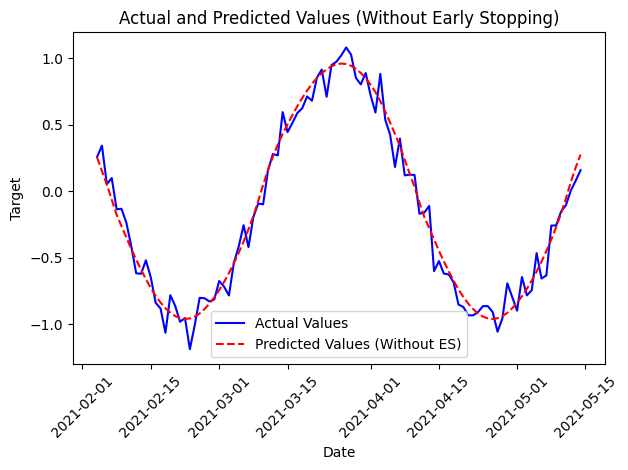

In [16]:
# Plot actual vs. predicted values without Early Stopping
plt.plot(test_df.index, y_test, label='Actual Values', color='blue')  # Plot actual values
plt.plot(test_df.index, y_pred_without_es, label='Predicted Values (Without ES)', color='red', linestyle='--')  
# Plot predicted values without Early Stopping

plt.title('Actual and Predicted Values (Without Early Stopping)')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility
plt.ylabel('Target')  # Set the y-axis label
plt.legend()  # Show the legend
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plot

In [17]:
# Create the model
model_with_es = create_lstm_model()  
# Initialize a new instance of the LSTM model using the `create_lstm_model` function. This model will be trained with Early Stopping.

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  
# Set up the Early Stopping callback to monitor the validation loss (`val_loss`).
# The `patience` parameter is set to 10, meaning training will stop if the validation loss does not improve for 10 consecutive epochs.
# `restore_best_weights=True` ensures that the model weights are restored to the best epoch's weights when training stops early, avoiding overfitting.

# Train the model with Early Stopping
history_with_es = model_with_es.fit(X_train, y_train,  
                                    # Train the model using the training data (`X_train`, `y_train`).
                                    
                                    validation_data=(X_test, y_test),  
                                    # Use the testing data (`X_test`, `y_test`) as the validation set to monitor performance during training.
                                    
                                    epochs=100,  
                                    # Set the maximum number of epochs to 500, allowing up to 500 iterations over the training data.
                                    
                                    batch_size=32,  
                                    # Set the batch size to 32, meaning the model will update its weights after processing every 32 samples.
                                    
                                    callbacks=[early_stopping],  
                                    # Include the Early Stopping callback in the training process to stop training 
                                    # if the model's performance stops improving.
                                    
                                    verbose=0)  
                                    # Set verbosity to 0 to suppress the output during training, meaning no progress output will be 


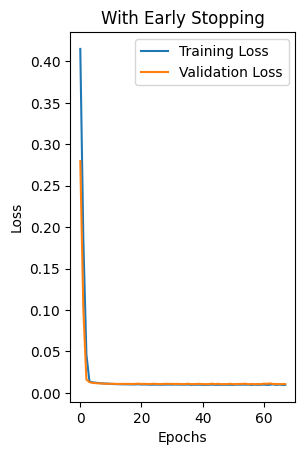

In [18]:
# With Early Stopping
plt.subplot(1, 2, 2)
plt.plot(history_with_es.history['loss'], label='Training Loss')
plt.plot(history_with_es.history['val_loss'], label='Validation Loss')
plt.title('With Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Predictions for both models
y_pred_with_es = model_with_es.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


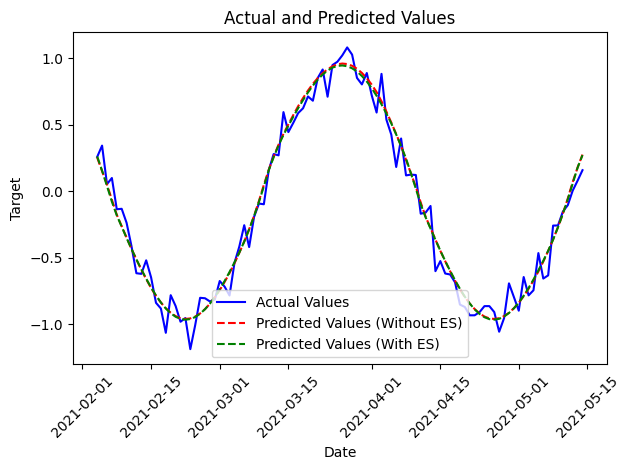

In [20]:
# Plot actual vs predicted for both models
plt.plot(test_df.index, y_test, label='Actual Values', color='blue')  # Plot actual values
plt.plot(test_df.index, y_pred_without_es, label='Predicted Values (Without ES)', color='red', linestyle='--')  
# Plot predicted values without Early Stopping
plt.plot(test_df.index, y_pred_with_es, label='Predicted Values (With ES)', color='green', linestyle='--')  
# Plot predicted values with Early Stopping

plt.title('Actual and Predicted Values')  # Set the title
plt.xlabel('Date')  # Set the x-axis label
# Rotate date labels and format them for better visibility
plt.xticks(rotation=45)  # Rotate the x-axis labels
plt.tight_layout()  # Adjust the layout to prevent overlap
plt.ylabel('Target')  # Set the y-axis label
plt.legend()  # Show the legend

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots